13357   2021-12-03
13358   2021-12-06
13359   2021-12-07
13453   2022-04-22
13454   2022-04-25
13455   2022-04-26
13456   2022-04-27
13458   2022-04-29
13544   2022-09-01
13545   2022-09-02
13546   2022-09-06
13784   2023-08-17
13785   2023-08-18
Name: Date, dtype: datetime64[ns]


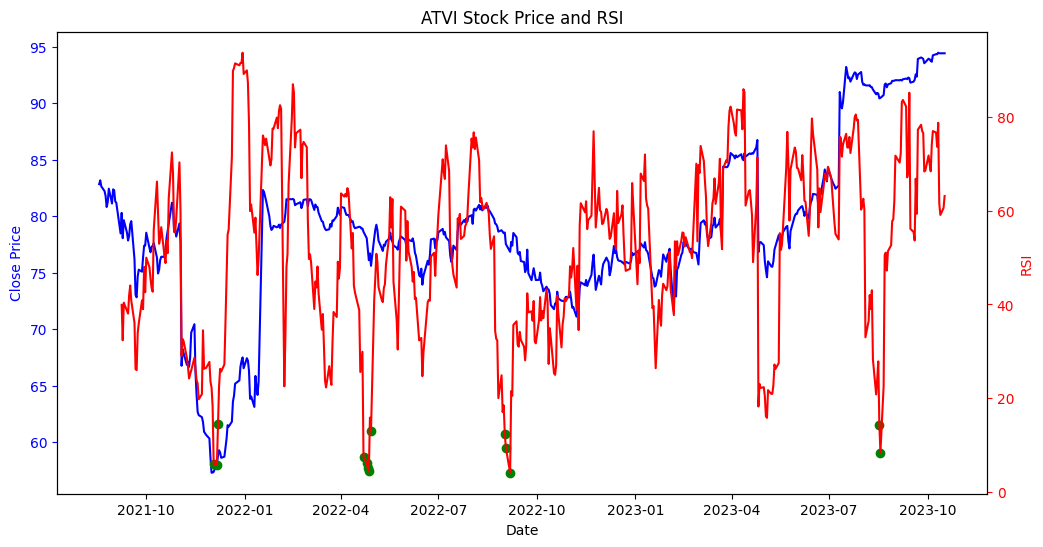

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
data = pd.read_csv("tech_stock_data.csv", parse_dates=["Date"])
atvi_data = data[data['ticker'] == 'ATVI'][["Date","Close"]]
atvi_data = atvi_data[atvi_data['Date'] >= '2021-08-18']


# 计算价格变动
atvi_data['Price Gain'] = atvi_data['Close'].diff()

# 计算平均涨幅和跌幅
atvi_data['Average Gain'] = atvi_data['Price Gain'].clip(lower=0).rolling(window=14).mean()
atvi_data['Average Loss'] = -atvi_data['Price Gain'].clip(upper=0).rolling(window=14).mean()

# 计算相对强弱指数 (RSI)
atvi_data['RS'] = atvi_data['Average Gain'] / atvi_data['Average Loss']
atvi_data['RSI'] = 100 - (100 / (1 + atvi_data['RS']))
rsi_below_30_dates = atvi_data[atvi_data['RSI'] < 15]['Date']
print(rsi_below_30_dates)

# 绘制股价和RSI图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制股价
ax1.plot(atvi_data['Date'], atvi_data['Close'], label='ATVI Close Price', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params('y', colors='b')

# 创建第二个y轴用于绘制RSI
ax2 = ax1.twinx()
ax2.plot(atvi_data['Date'], atvi_data['RSI'], label='RSI', color='r')
ax2.set_ylabel('RSI', color='r')
ax2.tick_params('y', colors='r')

# 在RSI小于30的点上标记
ax2.scatter(rsi_below_30_dates, atvi_data[atvi_data['Date'].isin(rsi_below_30_dates)]['RSI'], color='g', label='RSI < 30')

plt.title('ATVI Stock Price and RSI')
plt.show()


In [3]:
import pandas as pd

class StockSimulator:
    def __init__(self, data):
        self.data = data
        self.balance = 100000
        self.holdings = {}
        self.history = []

    def buy_stock(self, symbol , price, date):
        quantity = int(self.balance / price)
        cost = quantity * price
        if cost > self.balance:
            print("The balance is insufficient to purchase shares.")
            return

        self.balance -= cost
        if symbol in self.holdings:
            self.holdings[symbol] += quantity
        else:
            self.holdings[symbol] = quantity

        self.history.append((date, 'BUY', symbol, quantity, price))
        print(f"{date} buy {quantity} shares {symbol} successed，price: {price}，gross outcome {cost}，balance: {self.balance}.")

    def sell_stock(self, symbol, price, date):
        if symbol not in self.holdings or self.holdings[symbol] <= 0:
            print("The position is not enough to sell the stock.")
            return

        quantity = self.holdings[symbol]
        revenue = quantity * price
        self.balance += revenue
        self.holdings[symbol] -= quantity

        self.history.append((date, 'SELL', symbol, quantity, price))
        print(f"{date} sell {quantity} shares {symbol} successed，price: {price}，gross income {revenue}，balance: {self.balance}.")

    def execute_strategy(self, short_window, long_window):
        self.data['signal'] = 0.0
        # 计算短期均线和长期均线
        self.data['short_mavg'] = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        self.data['long_mavg'] = self.data['Close'].ewm(span=long_window, adjust=False).mean()

        # 生成交易信号
        self.data['signal'][short_window:] = np.where(self.data['short_mavg'][short_window:] > self.data['long_mavg'][short_window:], 1.0, 0.0)

        # 计算交易点
        self.data['positions'] = self.data['signal'].diff()
        
        # 执行交易策略
        transaction = self.data[self.data['positions'] != 0]
        for i in range(transaction.shape[0]):
            row = transaction.iloc[i]
            date = row['Date']
            signal = row['positions']
            price = row["Close"]
            symbol = "atvi"
            #date >datetime.strptime('2022-01-17', '%Y-%m-%d') and
            if  date < datetime.strptime('2023-04-26', '%Y-%m-%d'):
            #反转
                if signal == -1.0:
                    self.buy_stock(symbol, price, date)
                elif signal == 1.0:
                    self.sell_stock(symbol, price, date)
            #4.26反转回来
            elif date >=datetime.strptime('2022-04-26', '%Y-%m-%d'):
                if signal == 1.0:
                    self.buy_stock(symbol,price, date)
                elif signal == -1.0:
                    self.sell_stock(symbol,price, date)

    def get_balance(self):
        return self.balance

    def get_holdings(self):
        return self.holdings

    def get_transaction_history(self):
        return self.history
    
    def get_total_value(self):
        total_holdings_value = self.data['Close'].iloc[-1]*self.holdings["atvi"] 
        return self.balance + total_holdings_value

# 示例用法
# 假设已经有一个名为 atvi_data 的股票数据 DataFrame
# atvi_data = pd.read_csv('your_atvi_data.csv')  # 请根据实际情况修改文件路径


simulator = StockSimulator(atvi_data)
day1 = datetime.strptime('2021-12-03', '%Y-%m-%d')
prize1 = atvi_data[atvi_data["Date"] == day1][["Close"]].iloc[0, 0]
simulator.buy_stock("atvi", prize1 ,day1)
simulator.execute_strategy(short_window=7, long_window=70)
day2 = datetime.strptime('2023-10-17', '%Y-%m-%d')
prize2 = atvi_data[atvi_data["Date"] == day2][["Close"]].iloc[0, 0]
simulator.sell_stock("atvi", prize2 ,day2)
# 获取余额、持仓和交易历史
print("balance:", simulator.get_balance())
print("taken:", simulator.get_holdings())
history1 = simulator.get_transaction_history()


2021-12-03 00:00:00 buy 1743 shares atvi successed，price: 57.36000061035156，gross outcome 99978.48106384277，balance: 21.518936157226562.
2022-01-18 00:00:00 sell 1743 shares atvi successed，price: 82.30999755859375，gross income 143466.3257446289，balance: 143487.84468078613.
2022-04-27 00:00:00 buy 1885 shares atvi successed，price: 76.0999984741211，gross outcome 143448.49712371826，balance: 39.347557067871094.
2022-05-04 00:00:00 sell 1885 shares atvi successed，price: 79.23999786376953，gross income 149367.39597320557，balance: 149406.74353027344.
2022-05-09 00:00:00 buy 1936 shares atvi successed，price: 77.16999816894531，gross outcome 149401.11645507812，balance: 5.6270751953125.
2022-05-18 00:00:00 sell 1936 shares atvi successed，price: 77.91999816894531，gross income 150853.11645507812，balance: 150858.74353027344.
2022-05-19 00:00:00 buy 1940 shares atvi successed，price: 77.73999786376953，gross outcome 150815.5958557129，balance: 43.147674560546875.
2022-06-07 00:00:00 sell 1940 shares atvi

C:\Users\12040\AppData\Local\Temp\ipykernel_59232\1087515920.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['signal'][short_window:] = np.where(self.data['short_mavg'][short_window:] > self.data['long_mavg'][short_window:], 1.0, 0.0)


In [5]:
columns = ['Date', 'Action', 'Symbol', 'Quantity', 'Close']
df_history = pd.DataFrame(history1, columns=columns)
print(df_history)

         Date Action Symbol  Quantity      Close
0  2021-12-03    BUY   atvi      1743  57.360001
1  2022-01-18   SELL   atvi      1743  82.309998
2  2022-04-27    BUY   atvi      1885  76.099998
3  2022-05-04   SELL   atvi      1885  79.239998
4  2022-05-09    BUY   atvi      1936  77.169998
5  2022-05-18   SELL   atvi      1936  77.919998
6  2022-05-19    BUY   atvi      1940  77.739998
7  2022-06-07   SELL   atvi      1940  78.029999
8  2022-06-08    BUY   atvi      1950  77.629997
9  2022-07-01   SELL   atvi      1950  78.570000
10 2022-07-13    BUY   atvi      2017  75.959999
11 2022-07-19   SELL   atvi      2017  78.629997
12 2022-09-02    BUY   atvi      2046  77.529999
13 2022-11-23   SELL   atvi      2046  76.589996
14 2022-11-25    BUY   atvi      2133  73.470001
15 2022-12-02   SELL   atvi      2133  75.760002
16 2023-01-19    BUY   atvi      2190  73.760002
17 2023-01-30   SELL   atvi      2190  75.959999
18 2023-02-06    BUY   atvi      2324  71.580002
19 2023-02-14   SELL

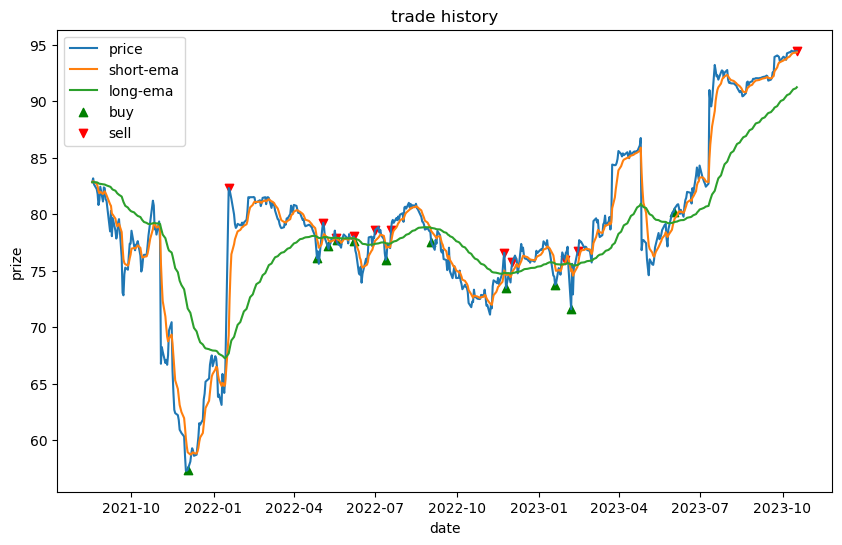

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(atvi_data['Date'], atvi_data['Close'], label='price')
plt.plot(atvi_data['Date'], atvi_data['short_mavg'], label='short-ema')
plt.plot(atvi_data['Date'], atvi_data['long_mavg'], label='long-ema')

# 标记买入和卖出点,反转
buy_signals = df_history[df_history['Action'] == "BUY"]
sell_signals = df_history[df_history['Action'] == "SELL"]

plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='g', label='buy')
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='r', label='sell')

# 设置图形属性
plt.title('trade history')
plt.xlabel('date')
plt.ylabel('prize')
plt.legend()
plt.show()

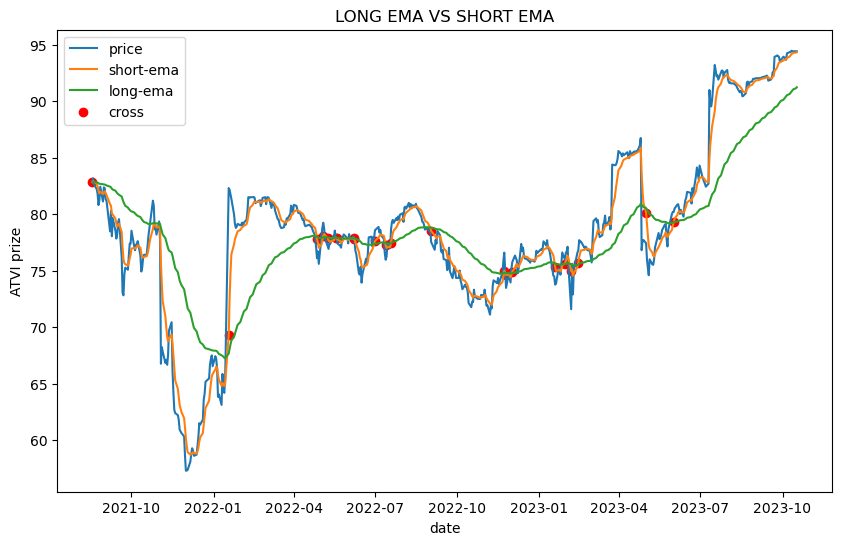

In [7]:
#1 .short,long,交点
plt.figure(figsize=(10, 6))
plt.plot(atvi_data['Date'], atvi_data['Close'], label='price')
plt.plot(atvi_data['Date'], atvi_data['short_mavg'], label='short-ema')
plt.plot(atvi_data['Date'], atvi_data['long_mavg'], label='long-ema')
intercross = atvi_data[atvi_data['positions'] != 0]
plt.scatter(intercross['Date'], intercross['short_mavg'], color='r', label='cross')
plt.title('LONG EMA VS SHORT EMA')
plt.xlabel('date')
plt.ylabel('ATVI prize')
plt.legend()
plt.show()

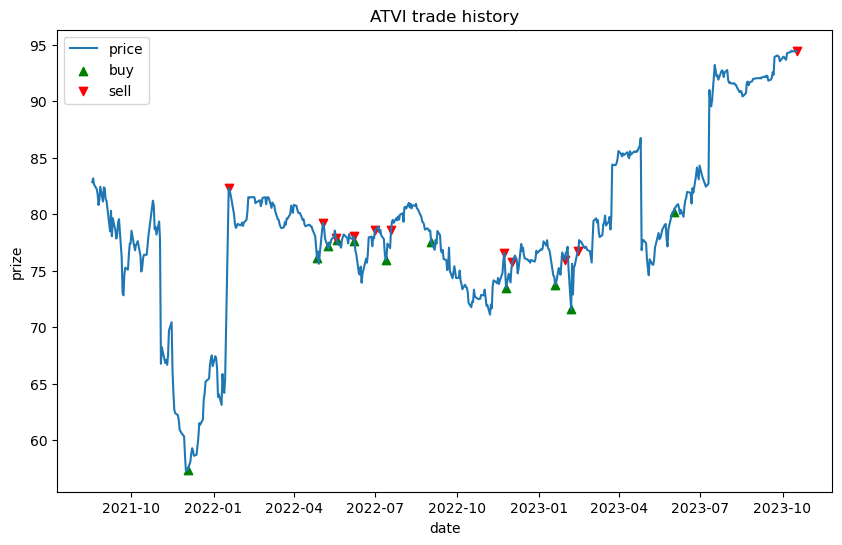

In [8]:
#2 . 只有交易点
plt.figure(figsize=(10, 6))
plt.plot(atvi_data['Date'], atvi_data['Close'], label='price')
# 标记买入和卖出点,反转
buy_signals = df_history[df_history['Action'] == "BUY"]
sell_signals = df_history[df_history['Action'] == "SELL"]

plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='g', label='buy')
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='r', label='sell')

# 设置图形属性
plt.title('ATVI trade history')
plt.xlabel('date')
plt.ylabel('prize')
plt.legend()
plt.show()

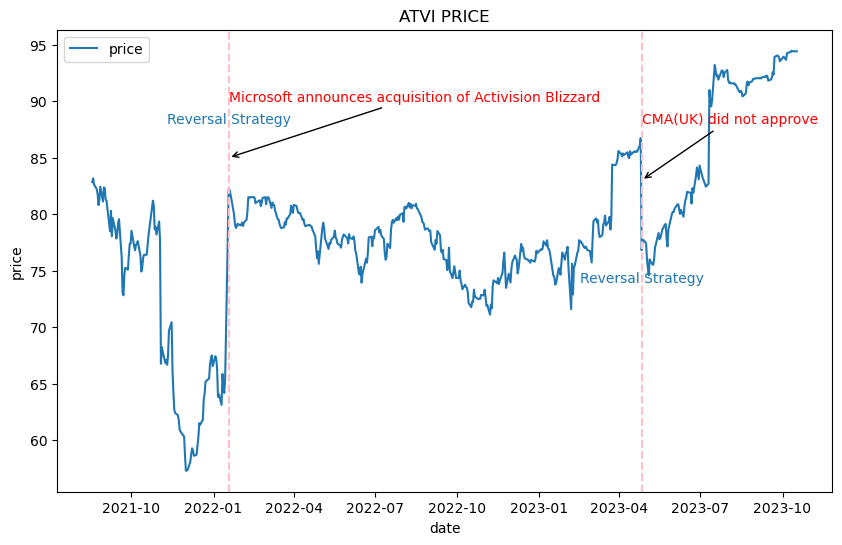

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime

# 获取颜色映射
colors = plt.get_cmap('tab10').colors

plt.figure(figsize=(10, 6))

# 添加整个图形的背景
# plt.axhspan(atvi_data['Close'].min(), atvi_data['Close'].max(), facecolor='lightgray', alpha=0.5)

plt.plot(atvi_data['Date'], atvi_data['Close'], label='price')

# 在2023.4.26和2022.01.18这两天添加垂直线
event_date1 = datetime.strptime('2023-04-26', '%Y-%m-%d')
event_date2 = datetime.strptime('2022-01-18', '%Y-%m-%d')
plt.axvline(x=event_date1, color='pink', linestyle='--')
plt.axvline(x=event_date2, color='pink', linestyle='--')

# 添加文字注释和箭头
plt.annotate('CMA(UK) did not approve', xy=(event_date1, 83),
             xytext=(event_date1, 88),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='r')

plt.annotate('Microsoft announces acquisition of Activision Blizzard', xy=(event_date2, 85),
             xytext=(event_date2, 90),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='r')

# 在指定位置添加文本，使用RGB值表示颜色
plt.text(event_date2, 88, "Reversal Strategy", fontsize=10, color=(0.1216, 0.4667, 0.7059), ha='center')  # RGB值表示颜色
plt.text(event_date1, 74, "Reversal Strategy", fontsize=10, color=(0.1216, 0.4667, 0.7059), ha='center')

# 设置图形属性
plt.title('ATVI PRICE')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()
